In [1]:
import os, tifffile, elasticdeform, random
from bg_atlasapi.bg_atlas import BrainGlobeAtlas
import numpy as np
import skimage.io as skio
import matplotlib.pyplot as plt
import cellfinder.analyse as cf
import bg_space as bgs
import imio
from cellfinder.analyse import analyse as cfa

In [2]:
atlas = BrainGlobeAtlas('allen_mouse_10um')
df1 = os.path.join(os.getcwd(), 'deformation_field_0.tiff')
def_field_1 = tifffile.imread(df1)
df2 = os.path.join(os.getcwd(), 'deformation_field_1.tiff')
def_field_2 = tifffile.imread(df2)
df3 = os.path.join(os.getcwd(), 'deformation_field_2.tiff')
def_field_3 = tifffile.imread(df3)
df_fields = [def_field_1, def_field_2, def_field_3]

(1260, 720, 1027)
(1320, 800, 1140)


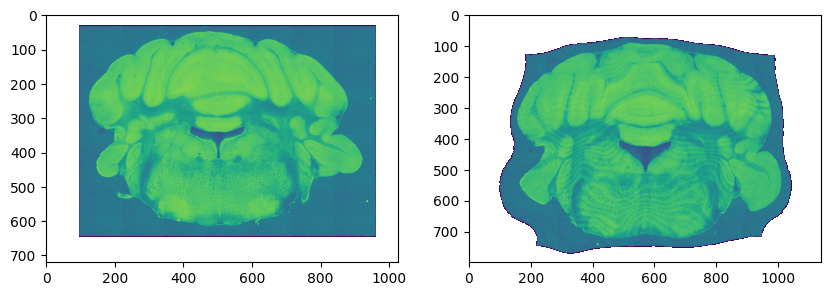

In [3]:
f, axs = plt.subplots(1,2, figsize=(10,5))

dsu = os.path.join(os.getcwd(), 'downsampled.tiff')
ds_unreg = tifffile.imread(dsu)
ds_unreg_crop = ds_unreg[922, :, :] # z, y, x
axs[0].imshow(ds_unreg_crop, norm='log')
print(ds_unreg.shape)

dsr = os.path.join(os.getcwd(), 'downsampled_standard.tiff')
ds_reg = tifffile.imread(dsr)
ds_reg_crop = ds_reg[1100, :, :] # z, y, x
axs[1].imshow(ds_reg_crop, norm='log')
print(ds_reg.shape)

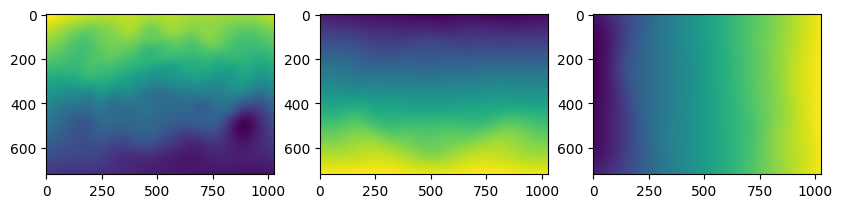

In [4]:
f, axs = plt.subplots(1,3, figsize=(10,5))
axs[0].imshow(def_field_1[922,:,:]) # z
axs[1].imshow(def_field_2[922,:,:]) # y
axs[2].imshow(def_field_3[922,:,:]) # x

In [5]:
# TRANSFORM PIXELS AT COORDINATES FROM RAW DATA SPACE TO ATLAS SPACE
def transform_cells_from_raw(cells):
    orientation = 'psl'
    voxel_sizes = [5,2,2]
    signal_planes = 'G:\\SC029\\r'
    source_shape = tuple(imio.get_size_image_from_file_paths(signal_planes).values())
    source_shape = (source_shape[2], source_shape[1], source_shape[0])
    print(f'Source space: {source_shape}')
    deformation_field_paths = [df1, df2, df3]
    print(deformation_field_paths)

    source_space = bgs.AnatomicalSpace(
            orientation,
            shape=source_shape,
            resolution=[float(i) for i in voxel_sizes],
        )
    downsampled_space = bgs.AnatomicalSpace(
            orientation,
            shape=atlas.shape,
            resolution=[float(i) for i in voxel_sizes],
        )
    print(f'Source space: {atlas.shape}')

    transformed_cells = cfa.transform_points_to_atlas_space(
            cells,
            source_space,
            atlas,
            deformation_field_paths,
            downsampled_space,
            downsampled_points_path=None,
            atlas_points_path=None,
        )
    return transformed_cells

In [6]:
def transform_cells_from_ds(downsampled_points):
    deformation_field_paths = [df1, df2, df3]
    print(deformation_field_paths)

    transformed_cells = cfa.transform_points_downsampled_to_atlas_space(
            downsampled_points,
            atlas,
            deformation_field_paths,
        )
    return transformed_cells

In [8]:
# method: transform a random subset of pixels in the entire stack
num_pixels_to_transform = 1_000_000

a = ds_unreg[:, :, :]
lstz, lsty, lstx = [i for i in range(0, a.shape[0])], [i for i in range(0, a.shape[1])], [i for i in range(0, a.shape[2])]
#lstz, lsty, lstx = [i for i in range(1000, 1250)], [i for i in range(300, 720)], [i for i in range(0, 500)]
dd = np.array([[random.choice(lstz) for _ in range(num_pixels_to_transform)],
               [random.choice(lsty) for _ in range(num_pixels_to_transform)],
               [random.choice(lstx) for _ in range(num_pixels_to_transform)]])
pts = dd.T

atlas_space = np.zeros((1320, 800, 1140))
transformed_pts = transform_cells_from_ds(pts)

for pt, pt_transformed in zip(pts, transformed_pts):
    try:
        atlas_space[tuple(pt_transformed)] = a[tuple(pt)] #print(f'coordinate was in bounds. coord = {coord}, val = {val}')
    except (IndexError) as e: #print(f'Index {z, y, x} was out of bounds.')
        pass

['F:\\deformation_field_0.tiff', 'F:\\deformation_field_1.tiff', 'F:\\deformation_field_2.tiff']


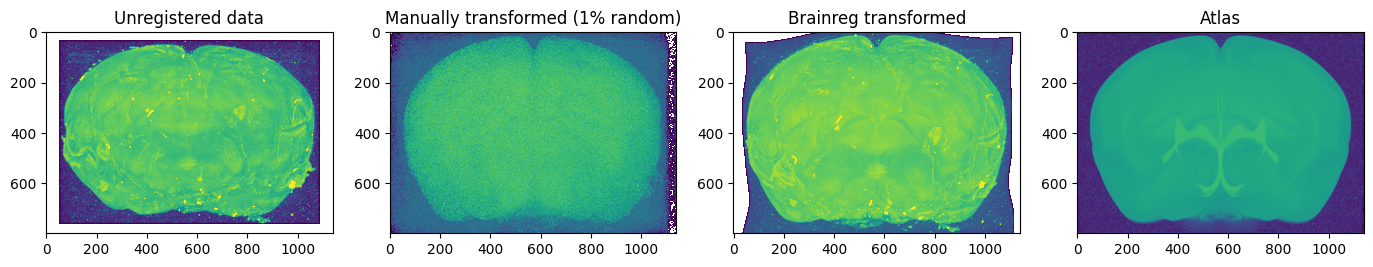

In [9]:
vmax = 10_000
f, axs = plt.subplots(1,4, figsize=(17,6))
x_pad = int((atlas_space.shape[2] - ds_unreg.shape[2]) / 2)
y_pad = int((atlas_space.shape[1] - ds_unreg.shape[1]) / 2)
unregistered = np.pad(ds_unreg, ((0,0),(y_pad,y_pad),(x_pad,x_pad))) # pad x and y to match the others
axs[0].imshow(np.max(unregistered, axis=0), norm='log', vmax=vmax); axs[0].set_title('Unregistered data');
axs[1].imshow(np.max(atlas_space, axis=0), norm='log', vmax=vmax); axs[1].set_title('Manually transformed (1% random)');
axs[2].imshow(np.max(ds_reg, axis=0), norm='log', vmax=vmax); axs[2].set_title('Brainreg transformed');
axs[3].imshow(np.max(atlas.reference, axis=0), norm='log', vmax=vmax); axs[3].set_title('Atlas');
#plt.colorbar(im3, ax=axs[3]);
# check that the atlas_space actually looks the same as ds_reg on individual layers

## show that the transform works by transforming a set of points based on their destination (a small cube of known shape)

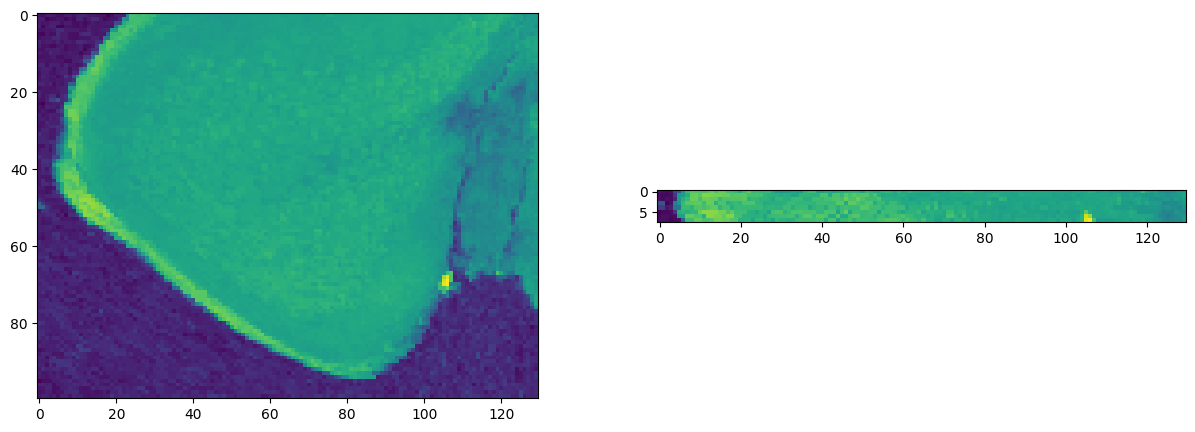

In [7]:
bounds_x, bounds_y, bounds_z = (150,280), (520,620), (1080,1088) # flocculus test
#bounds_x, bounds_y, bounds_z = (750,880), (50,120), (600,610) # cortex test
ds_reg_crop = ds_reg[slice(*bounds_z), slice(*bounds_y), slice(*bounds_x)] # z, y, x

f, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
ax1.imshow(np.max(ds_reg_crop, axis=0), norm='log')
ax2.imshow(np.max(ds_reg_crop, axis=1), norm='log')

In [8]:
sc_field_1 = def_field_1 * int(1000 / atlas.resolution[0])
sc_field_2 = def_field_2 * int(1000 / atlas.resolution[1])
sc_field_3 = def_field_3 * int(1000 / atlas.resolution[2])

In [9]:
masked_field_z = (sc_field_1 >= bounds_z[0]) & (sc_field_1 <= bounds_z[1]) #, bounds_x[0], bounds_x[1]) # mask deformation fields by whether their coordinate appears in the given atlas cube
masked_field_y = (sc_field_2 >= bounds_y[0]) & (sc_field_2 <= bounds_y[1])
masked_field_x = (sc_field_3 >= bounds_x[0]) & (sc_field_3 <= bounds_x[1])
intersection = np.nonzero((masked_field_x!=0) & (masked_field_y!=0) & (masked_field_z!=0)) # take the intersection of the masked deformation fields, thus obtaining the indexes of the unregistered image that map onto the cube

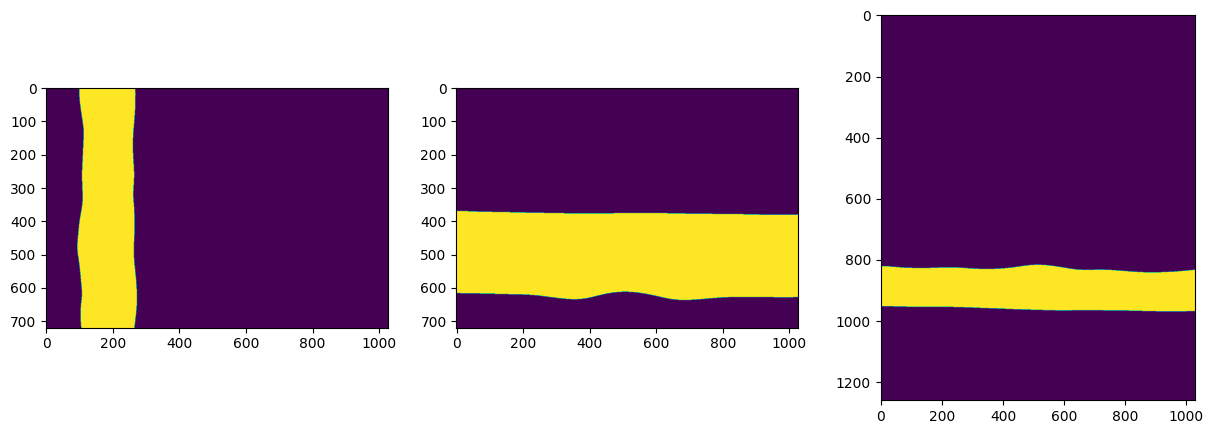

In [10]:
f, axs = plt.subplots(1,3, figsize=(15,5))
axs[0].imshow(np.max(masked_field_x, axis=0))
axs[1].imshow(np.max(masked_field_y, axis=0))
axs[2].imshow(np.max(masked_field_z, axis=1))

In [11]:
points_to_transform = np.array(intersection).T

In [12]:
transformed_pts = transform_cells_from_ds(points_to_transform)

['F:\\deformation_field_0.tiff', 'F:\\deformation_field_1.tiff', 'F:\\deformation_field_2.tiff']


In [13]:
atlas_space = np.zeros((1320, 800, 1140))
for pt, pt_transformed in zip(points_to_transform, transformed_pts):
    try:
        atlas_space[tuple(pt_transformed)] = ds_unreg[tuple(pt)] #print(f'coordinate was in bounds. coord = {coord}, val = {val}')
    except (IndexError) as e: #print(f'Index {z, y, x} was out of bounds.')
        pass

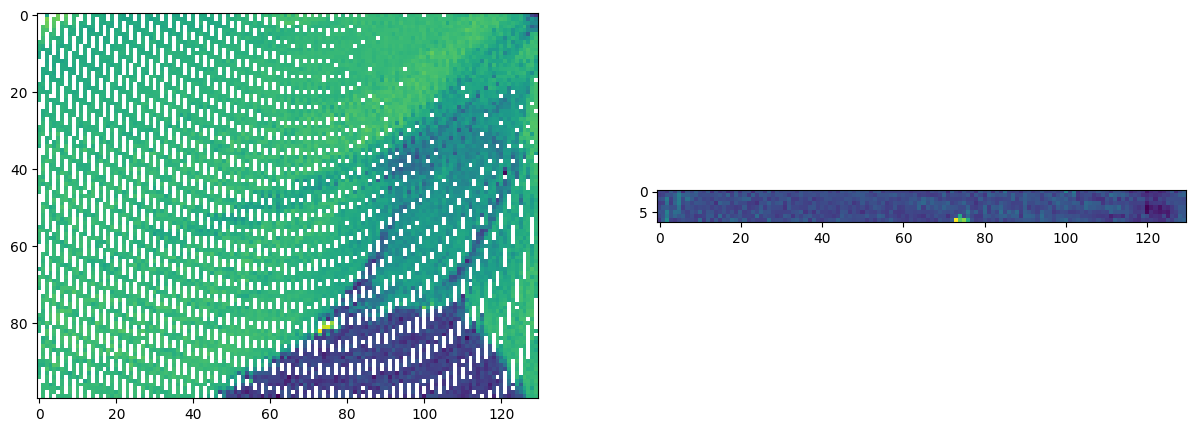

In [14]:
atlas_space_crop = atlas_space[slice(*bounds_z), slice(*bounds_y), slice(*bounds_x)] # z, y, x
f, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
ax1.imshow(np.max(atlas_space_crop, axis=0), norm='log')
ax2.imshow(np.max(atlas_space_crop, axis=1), norm='log')

In [153]:
for x, y, z in zip(*intersection):
    pass

In [ ]:
# convert between downsampled and raw data spaces:

subtracted_stack_files = btf.open_transformed_brain(self)
num_slices = len(subtracted_stack_files)
print(num_slices)
first_im = np.load(subtracted_stack_files[0])
print(first_im.shape)

# get values to scale pixels into registered atlas space
z_scalar = self.atlas.shape[0] / num_slices
y_scalar = self.atlas.shape[1] / first_im.shape[0]
x_scalar = self.atlas.shape[2] / first_im.shape[1]
print(z_scalar,y_scalar,x_scalar)

z_coords, y_coords, x_coords = np.array([]), np.array([]), np.array([])
for z, im in enumerate(tqdm(subtracted_stack_files)):
    # take reverse of z
    atlas_z = int((num_slices - z) * z_scalar) - 1 # pick the closest atlas slice, -1 to start from zero
    y_pxs, x_pxs = np.nonzero(np.load(im)) # get coordinates of 1s in this slice
    x_atlas = list(map(lambda x: int(x * x_scalar), x_pxs))
    y_atlas = list(map(lambda y: int(y * y_scalar), y_pxs))
    x_coords = np.append(x_coords, x_atlas)
    y_coords = np.append(y_coords, y_atlas)
    z_coords = np.append(z_coords, [atlas_z] * len(x_pxs)) # add all the repeating z coordinates for this slice
    if check_after == z:
        atlas_im = np.where(self.atlas[atlas_z] > 0, 1, 0)
        f, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(atlas_im, cmap='Greens', interpolation=None)
        ax.scatter(x_atlas, y_atlas, s=1)
    coords = [list(x_coords.astype(int)), list(y_coords.astype(int)), list(z_coords.astype(int))]